In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.ToTensor()

In [3]:
mbti_df = pd.read_csv('crop/all.csv')

photo_df = pd.DataFrame(columns=['photo'], dtype= 'object')

# put the photo data into a dataframe
for i in range(len(mbti_df)):
    image = transform(Image.open('crop/' + mbti_df['file_name'][i]))
    photo_df.loc[i] = [image]

mbti_df = mbti_df['MBTI']

mbti_df.head()

0    istj
1    istj
2    istj
3    istj
4    istj
Name: MBTI, dtype: object

In [4]:
photo_df.iloc[0][0].shape

torch.Size([1, 64, 64])

In [5]:
alphabet = ['s', 'n']

# if mbti_df['MBTI'] includes alphabet[0], then mbti_df['MBTI'] = 1, else 0
mbti_df = mbti_df.apply(lambda x: 1 if alphabet[0] in x else 0)

mbti_df.head()

0    1
1    1
2    1
3    1
4    1
Name: MBTI, dtype: int64

In [6]:
#print the statistics of the mbti_df
print(mbti_df.value_counts())

0    578
1    467
Name: MBTI, dtype: int64


In [7]:
# train_data includes the element of 2-dim tensor
train_data = photo_df['photo'].values
train_label = mbti_df.values

In [8]:
#전체 data 중 train의 비율
train_ratio = 0.6

train_idx = np.random.choice(len(train_data), int(len(train_data) * train_ratio), replace=False)
test_idx = np.array(list(set(range(len(train_data))) - set(train_idx)))

test_data = train_data[test_idx]
test_label = train_label[test_idx]

train_data = train_data[train_idx]
train_label = train_label[train_idx]

In [9]:
#defining model
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

class MBTI_Dataset(Dataset):
    def __init__(self, train_label, train_data):
        self.train_label = train_label
        self.train_data = train_data

    def __len__(self):
        return len(self.train_label)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mbti = self.train_label[idx]
        photo = self.train_data[idx]

        return mbti, photo

# parameter 값은 이것을 변경해주세요
in_ch1 = 1
out_ch1 = 6
ker1 = 4
stride1 = 1
pad1 = 2

out_ch2 = 16
ker2 = 3
stride2 = 1
pad2 = 0

out_ch3 = 32
ker3 = 2
stride3 = 1
pad3 = 0

out_ch4 = 64
ker4 = 2
stride4 = 1
pad4 = 0

out_ch5 = 128
ker5 = 2
stride5 = 1
pad5 = 0


pool_size1 = 3
pool_size2 = 2
pool_size3 = 2
pool_size4 = 2
pool_size5 = 2


out_feat1 = 120
out_feat2 = 84
out_feat3 = 1


class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        input_height, input_width = input_shape

        self.conv1 = nn.Conv2d(in_channels = in_ch1, out_channels = out_ch1, kernel_size = ker1, stride = stride1, padding = pad1)
        self.pool1 = nn.MaxPool2d(pool_size1, pool_size1)

        output1_height, output1_width = (input_height - ker1 + 2 * pad1) / stride1 + 1, (input_width - ker1 + 2 * pad1) / stride1 + 1
        output1_height, output1_width = int(output1_height / pool_size1), int(output1_width / pool_size1)

        self.conv2 = nn.Conv2d(in_channels = out_ch1, out_channels = out_ch2, kernel_size = ker2, stride = stride2, padding = pad2)
        self.pool2 = nn.MaxPool2d(pool_size2, pool_size2)

        output2_height, output2_width = (output1_height - ker2 + 2 * pad2) / stride2 + 1, (output1_width - ker2 + 2 * pad2) / stride2 + 1
        output2_height, output2_width = int(output2_height / pool_size2), int(output2_width / pool_size2)

        self.conv3 = nn.Conv2d(in_channels = out_ch2, out_channels = out_ch3, kernel_size = ker3, stride = stride3, padding = pad3)
        self.pool3 = nn.MaxPool2d(pool_size3, pool_size3)

        output3_height, output3_width = (output2_height - ker3 + 2 * pad3) / stride3 + 1, (output2_width - ker3 + 2 * pad3) / stride3 + 1
        output3_height, output3_width = int(output3_height / pool_size3), int(output3_width / pool_size3)

        self.conv4 = nn.Conv2d(in_channels = out_ch3, out_channels = out_ch4, kernel_size = ker4, stride = stride4, padding = pad4)
        self.pool4 = nn.MaxPool2d(pool_size4, pool_size4)

        output4_height, output4_width = (output3_height - ker4 + 2 * pad4) / stride4 + 1, (output3_width - ker4 + 2 * pad4) / stride4 + 1
        output4_height, output4_width = int(output4_height / pool_size4), int(output4_width / pool_size4)

        self.fc1 = nn.Linear(out_ch4 * output4_height * output4_width, out_feat1)
        self.fc2 = nn.Linear(out_feat1, out_feat2)
        self.fc3 = nn.Linear(out_feat2, out_feat3)

    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        #print('1')
        x = self.pool2(F.relu(self.conv2(x)))
        #print('2')
        x = self.pool3(F.relu(self.conv3(x)))
        #print('3')
        x = self.pool4(F.relu(self.conv4(x)))
        #print('4')
        #x = self.pool5(F.relu(self.conv5(x)))
        #print('5')
        x = torch.flatten(x, 1)

        # 이 부분은 변경하셔도 괜찮아요. relu로 할지 sigmoid로 할지
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class cnn_model():
    def __init__(self, model, lr=0.01, epochs=100, momentum = 0.6):
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.momentum = momentum
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum = self.momentum)
    
    def fit(self, X_train, y_train):        
        self.trainloader = DataLoader(MBTI_Dataset(X_train, y_train), batch_size=64, shuffle=False)
        
        self.model.train()
        for epoch in range(self.epochs):
            for i, data in enumerate(self.trainloader):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                labels.unsqueeze_(1)
                loss = self.criterion(outputs, labels.float())
                loss.backward()
                self.optimizer.step()
    
    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(x.unsqueeze(0))
        return y_pred

    def get_params(self, deep=True):
        return {'lr': self.lr, 'epochs': self.epochs, 'momentum': self.momentum}

    def save(self, path):
        torch.save(self.model.state_dict(), path)

In [10]:
net = Net((train_data[0].shape[1], train_data[0].shape[2]))

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def cross_val_score(model, train_data, label, cv=5):
    k = cv
    kf = KFold(n_splits=k, random_state=42, shuffle=True)

    acc_score = []
    auc_score = []
    
    for train_index , test_index in kf.split(train_data):
        X_train , X_test = train_data[train_index],train_data[test_index]
        y_train , y_test = label[train_index] , label[test_index]
        
        if(np.unique(y_test).shape[0] == 1):
            print('only one class')
            continue

        model.fit(X_train,y_train)

        pred_values = []

        for i in range(len(X_test)):
            pred = model.predict(X_test[i])
            pred_values.append(pred.item())

        auc = roc_auc_score(y_test, pred_values)
        auc_score.append(auc)
        
    avg_acc_score = sum(acc_score)/k
    avg_auc_score = sum(auc_score)/k
    
    return avg_auc_score

In [12]:
# make tupes of (lr, momentum, epochs) randomly
# random cv를 몇번 돌릴 것인지...
random_cv_num = 20


# parameter 값이 이 범위 내에서 나옵니다
lrs = np.linspace(0.01, 0.06, 30)
momentums = np.linspace(0.0, 0.9, 20)
epochss = np.linspace(50, 200, 5, dtype=int)

params = [(lr, momentum, epochs) for lr in lrs for momentum in momentums for epochs in epochss]
np.random.shuffle(params)
params = params[:random_cv_num]

In [13]:
models = [cnn_model(net, lr, epochs, momentum) for lr, momentum, epochs in params]

cv_scores = []
cv_params = []

for model in models:
    cv_scores.append(np.mean(cross_val_score(model, train_data, train_label, cv=3)))
    cv_params.append(model.get_params())

cv_scores = np.array(cv_scores)
cv_params = np.array(cv_params)

best_params = cv_params[np.argmax(cv_scores)]
best_score = np.max(cv_scores)

KeyboardInterrupt: 

In [ ]:
print('Best lr: ', best_params['lr'], 'Best momentum: ', best_params['momentum'], 'Best epochs: ', best_params['epochs'])

Best lr:  0.047931034482758615 Best momentum:  0.0 Best epochs:  125


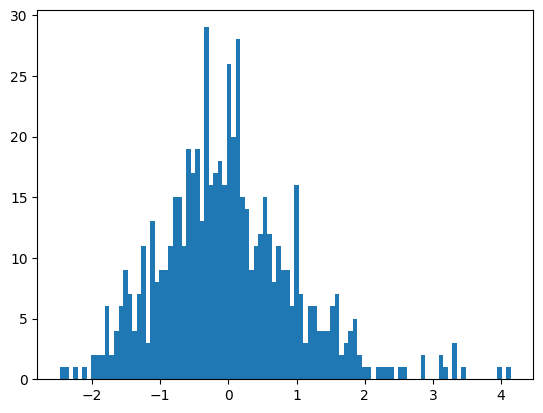

Best threshold:  0.6791999999998151
Best score for train set:  0.5502392344497608
0.5334928229665071
0.5287081339712919
the model is  0.4784688995215225 % better than random guess
roc auc score:  0.5221420860417576


In [16]:
#import roc curve
from sklearn.metrics import roc_curve

#calculate test accuracy score
#model = cnn_model(model = net, lr = best_params['lr'], momentum = best_params['momentum'], epochs = best_params['epochs'])
model = cnn_model(model = net, lr = 0.04, momentum = 0, epochs = 125)
model.fit(train_data, train_label)

train_pred_values = []

for i in range(len(train_data)):
    pred = model.predict(train_data[i])
    train_pred_values.append(pred.item())

#calculate mean and variance of train_pred
train_pred_values = np.array(train_pred_values)
train_pred_mean = np.mean(train_pred_values)
train_pred_var = np.var(train_pred_values)

#normalize train_pred_values
train_pred_values = (train_pred_values - train_pred_mean) / np.sqrt(train_pred_var)

# draw the histogram of train_pred_values
plt.hist(train_pred_values, bins=100)
plt.show()

best_threshold = 0
best_score = 0

for threshold in np.arange(-1, 1, 0.0001):
    y_pred = np.array(train_pred_values) > threshold
    score = accuracy_score(train_label, y_pred)
    if score > best_score:
        best_threshold = threshold
        best_score = score

print('Best threshold: ', best_threshold)
print('Best score for train set: ', best_score)

pred_values = []

for i in range(len(test_data)):
    pred = model.predict(test_data[i])
    pred_values.append(pred.item())

#quantize predictions
pred_values = np.array(pred_values)

#normalize pred_values
pred_values = (pred_values - train_pred_mean) / np.sqrt(train_pred_var)
guess3 = roc_auc_score(test_label, pred_values)

pred_values[pred_values >= best_threshold] = 1
pred_values[pred_values < best_threshold] = 0

#calculate accuracy score

guess1 = accuracy_score(test_label, pred_values)
print(guess1)

# random guess

pred_values = []

for i in range(len(test_data)):
    pred = 0
    pred_values.append(pred)

#quantize predictions
pred_values = np.array(pred_values)

#calculate accuracy score
guess2 = accuracy_score(test_label, pred_values)
print(guess2)

print('the model is ', (guess1 - guess2)*100, '% better than random guess')

print('roc auc score: ', guess3)

# save the model
model.save('cnn_trial1')

In [ ]:
# random guess

pred_values = []

for i in range(len(test_data)):
    pred = 0
    pred_values.append(pred)

#quantize predictions
pred_values = np.array(pred_values)

#calculate accuracy score
guess2 = accuracy_score(test_label, pred_values)
print(guess2)

0.5717703349282297


In [ ]:
print('the model is ', (guess1 - guess2)*100, '% better than random guess')

the model is  -2.8708133971291905 % better than random guess


In [ ]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_label, pred_values)

# calculate the best quantize threshold using roc curve
best_threshold = 0

for i in range(len(fpr)):
    if fpr[i] >= 0.1 and fpr[i] <= 0.2:
        best_threshold = thresholds[i]

pred_values = []

for i in range(len(test_data)):
    pred = model.predict(test_data[i])
    pred_values.append(pred.item())

#quantize predictions
pred_values = np.array(pred_values)

#normalize pred_values
pred_values = (pred_values - train_pred_mean) / np.sqrt(train_pred_var)

guess3 = roc_auc_score(test_label, pred_values)

pred_values[pred_values >= best_threshold] = 1
pred_values[pred_values < best_threshold] = 0

#calculate roc score
print('roc auc score: ', guess3)


roc auc score:  0.551444630248978
